# US Census Analysis (notebook 2 - machine learning analysis)

### Problem Statement

*"For this technical assessment, you have been tasked with identifying characteristics that are associated with a person making more or less than $50,000 per year"*

### Overview

This notebook is a continuation of Analysis_1. It contains the Machine Learning analysis, structured as follows:

1. **Feature selection and engineering**
- Binary encoding target variable
- Drop features that are not relevant, nested or multicolinear with other features
- Ordinally encode education
- One hot encode all other categorical variables

2. **Machine learning analysis**
- Random forest (to capture non-linear effects and non-linear interactions)
    - with a Partial Dependence Plot for interpretability
- Logistic regression
    - With plotted coefficients for interpretability

In [17]:
import pandas as pd

## Section 1: Feature selection and engineering

In [25]:
# Import from feather files
full_df = pd.read_feather('Data/Cleaned/census_income_full.feather')
train_df = pd.read_feather('Data/Cleaned/census_income_train.feather')
test_df = pd.read_feather('Data/Cleaned/census_income_test.feather')

In [19]:
# Encode target variable
def encode_income(income_str):
    # Check if the string implies >50K
    if '50000+.' in str(income_str) in str(income_str):
        return 1
    else:
        return 0

# Apply to all dataframes
full_df['income_binary'] = full_df['income'].apply(encode_income)
train_df['income_binary'] = train_df['income'].apply(encode_income)
test_df['income_binary'] = test_df['income'].apply(encode_income)

In [20]:
# Define list of columns to drop (see documentation for a more detailed explanation)
cols_to_drop = [
    'income',             
    'instance_weight',
    'year', 
    
    # Granularity vs Stability (Dropping detailed, keeping major/summary)
    'household_family_stat',           
    'detailed_occupation_recode',      
    'detailed_industry_recode',
    'state_prev_residence',        

    # Multicollinearity in Migration (Dropping these two, keeping 'migration_code_move_within_reg')
    'migration_msa',    
    'migration_reg'
]

# Drop function
def clean_dataframe(df, columns):
    df.drop(columns=columns, inplace=True, errors='ignore')
    return df

# Apply
full_df = clean_dataframe(full_df, cols_to_drop)
train_df = clean_dataframe(train_df, cols_to_drop)
test_df = clean_dataframe(test_df, cols_to_drop)


### Feature encoding

In [21]:
# Ordinally encode education
edu_order = {
    "Less than 1st grade": 1,
    "1st 2nd 3rd or 4th grade": 2,
    "5th or 6th grade": 3,
    "7th and 8th grade": 4,
    "9th grade": 5,
    "10th grade": 6,
    "11th grade": 7,
    "12th grade no diploma": 8,
    "High school graduate": 9,
    "Some college but no degree": 10,
    "Associates degree-occup /vocational": 11,
    "Associates degree-academic program": 11,
    "Bachelors degree(BA AB BS)": 12,
    "Masters degree(MA MS MEng MEd MSW MBA)": 13,
    "Prof school degree (MD DDS DVM LLB JD)": 14,
    "Doctorate degree(PhD EdD)": 15,
    "Children": 0
}

# Create the ordinal variable
full_df["education_ordinal"] = full_df["education"].map(edu_order)
train_df["education_ordinal"] = train_df["education"].map(edu_order)
test_df["education_ordinal"] = test_df["education"].map(edu_order)

# Remove old education column
full_df.drop(columns=["education"], inplace=True)
train_df.drop(columns=["education"], inplace=True)
test_df.drop(columns=["education"], inplace=True)

In [22]:
# Print all features and their types for verification
print(full_df.dtypes)

age                                 int64
class_of_worker                    object
wage_per_hour                       int64
enrolled_last_week                 object
marital_status                     object
major_industry_code                object
major_occupation_code              object
race                               object
hispanic_origin                    object
sex                                object
labor_union_member                 object
reason_for_unemployment            object
employment_status                  object
capital_gains                       int64
capital_losses                      int64
dividends                           int64
tax_filer_status                   object
region_prev_residence              object
household_summary                  object
migration_within_reg               object
lived_here_1yr_ago                 object
sunbelt_migration                  object
num_persons_worked_for_employer     int64
Presence_of_parents               

In [23]:
# One hot encode all remaining categorical variables
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"Encoding the following columns: {categorical_cols}")

# Train set
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=False)

# Test set
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=False)

# ALIGNMENT (if a column exists in Train but not Test, add it to Test with 0s, if a column exists in Test but not Train, drop it from Test)
final_test = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)

# Check
print(f"Train shape: {train_encoded.shape}")
print(f"Test shape:  {final_test.shape}")

# Verify identical
if list(train_encoded.columns) == list(final_test.columns):
    print("SUCCESS: aligned.")
else:
    print("WARNING: mismatch")


Encoding the following columns: ['class_of_worker', 'enrolled_last_week', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'labor_union_member', 'reason_for_unemployment', 'employment_status', 'tax_filer_status', 'region_prev_residence', 'household_summary', 'migration_within_reg', 'lived_here_1yr_ago', 'sunbelt_migration', 'Presence_of_parents', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'self_employed', 'veterans_admin_questionnaire', 'veterans_benefits']
Train shape: (199522, 286)
Test shape:  (99761, 286)
SUCCESS: aligned.


In [24]:
# Define target column
target_col = 'income_binary'

# Create X (Features) and y (Target)
X_train = train_encoded.drop(columns=[target_col])
y_train = train_encoded[target_col]

# Smae for test
X_test = final_test.drop(columns=[target_col])
y_test = final_test[target_col]

# Check
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (199522, 285)
y_train shape: (199522,)


## Section 2: Machine learning analysis

**Why machine learning?**

Our previous analysis has focused on average, marginal, and mostly linear relationships. Machine learning models can extend this by capturing:
1. Non-linear relationships between features and the target variables
2. Interaction effects between 2+ features and the target variable (e.g., how does receiving  aaveterans benefits and being privately employed affect the chance of earning >$50,000)
3. Out-of-sample predictive performance to evaluate whether patterns generalise

I will use:
- **Random Forest**: Performs well on tabular survey data, offers model-level interpretability and is efficient
- **Logistic regression**: Included as an interpretable baseline to validate the Random Forest

### Mode 1: Random Forest

The Random Forest model was tuned using a grid search over four key hyperparameters:

- **Number of trees** (`n_estimators`): More trees generally improve performance but increase computation time.

- **Maximum tree depth** (`max_depth`): Limits how deep each tree can grow, preventing overfitting by stopping trees from becoming overly complex.

- **Minimum samples per leaf** (`min_samples_leaf`): Sets the minimum number of samples required to form a leaf node.

- **Number of features considered at each split** (`max_features`): Introduces randomness by limiting the subset of features used when splitting nodes. This improves robustness by reducing correlation between trees.

Hyperparameters were selected using three-fold cross-validation on the training set, with the objective of maximising balanced accuracy to account for class imbalance (i.e., if the model guessed 0 every time it would achieve 94% accuracy).

Interpretability is supported via:

- **Feature importance plots**: Highlight which variables contribute most to prediction.  
- **Partial dependence plots**: Illustrate how individual features influence the model’s predicted probabilities while holding other features constant.

In [9]:
# Import modules for modeling
import sys
import os
from models import random_forest

# Modeling (Grid Search & Training)
best_model = random_forest.tune_and_train(X_train, y_train)

Starting Grid Search on 199522 rows...
Optimizing: Depth, Estimators, Min_Leaf, and Max_Features
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
Best CV Score (Balanced Acc): 86.60%


--- Model Evaluation ---
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93575
           1       0.30      0.88      0.45      6186

    accuracy                           0.87     99761
   macro avg       0.65      0.87      0.69     99761
weighted avg       0.95      0.87      0.90     99761



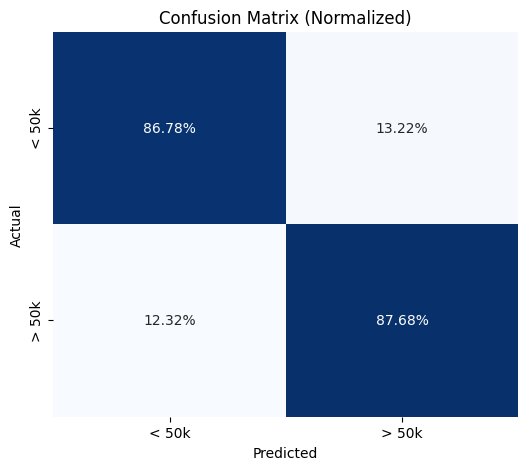

--- Feature Importance Analysis ---


/Users/gianjaeger/Desktop/Dataiku_assessment/models/random_forest.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


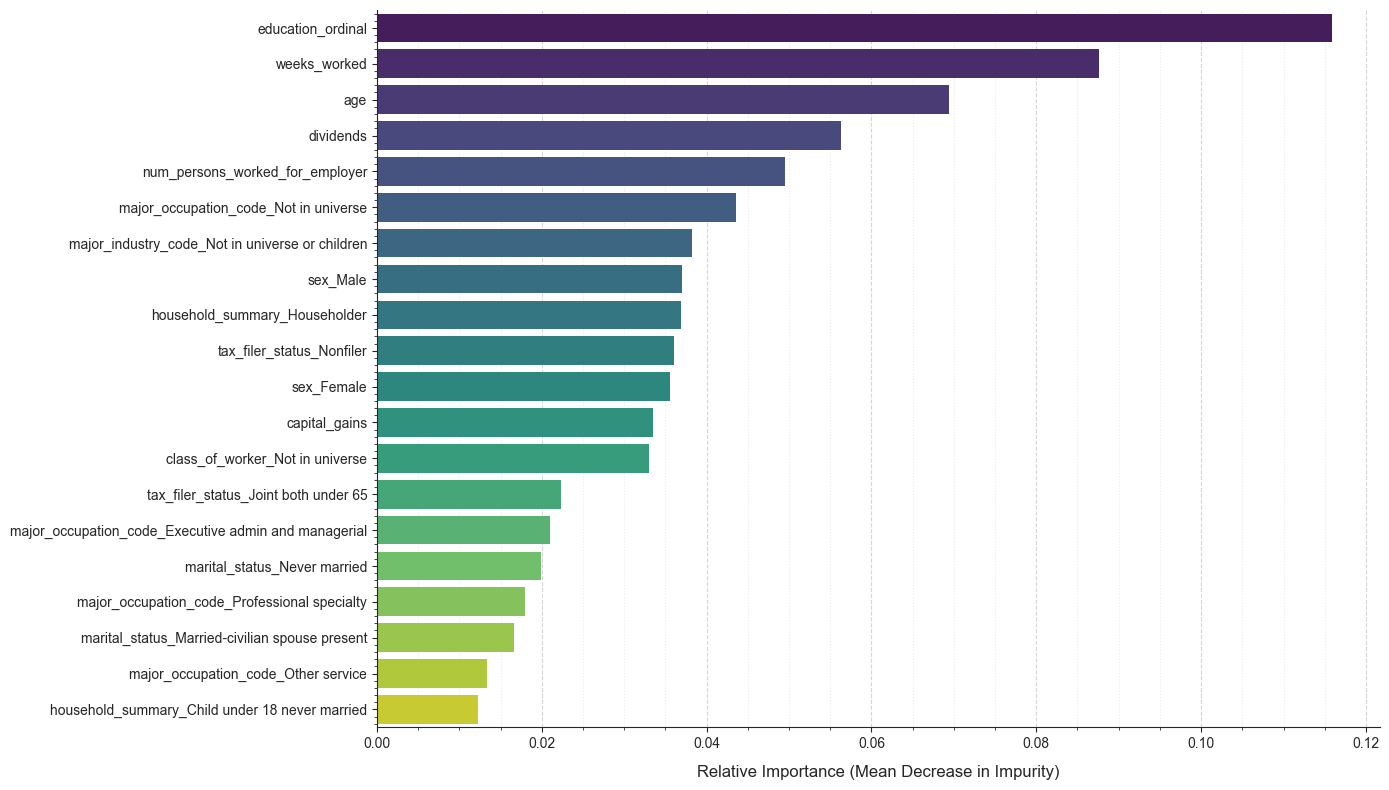

In [10]:
# Evaluation on held-out test set
random_forest.evaluate_model(best_model, X_test, y_test)

# Visualization of key characteristics
print("--- Feature Importance Analysis ---")
random_forest.plot_feature_importance(best_model, X_train.columns, top_n=20)

**See HOW exactly our numeric features impact the output**

/Users/gianjaeger/Desktop/Dataiku_assessment/assessment/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


Generating Partial Dependence Plots...


/Users/gianjaeger/Desktop/Dataiku_assessment/assessment/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/gianjaeger/Desktop/Dataiku_assessment/assessment/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


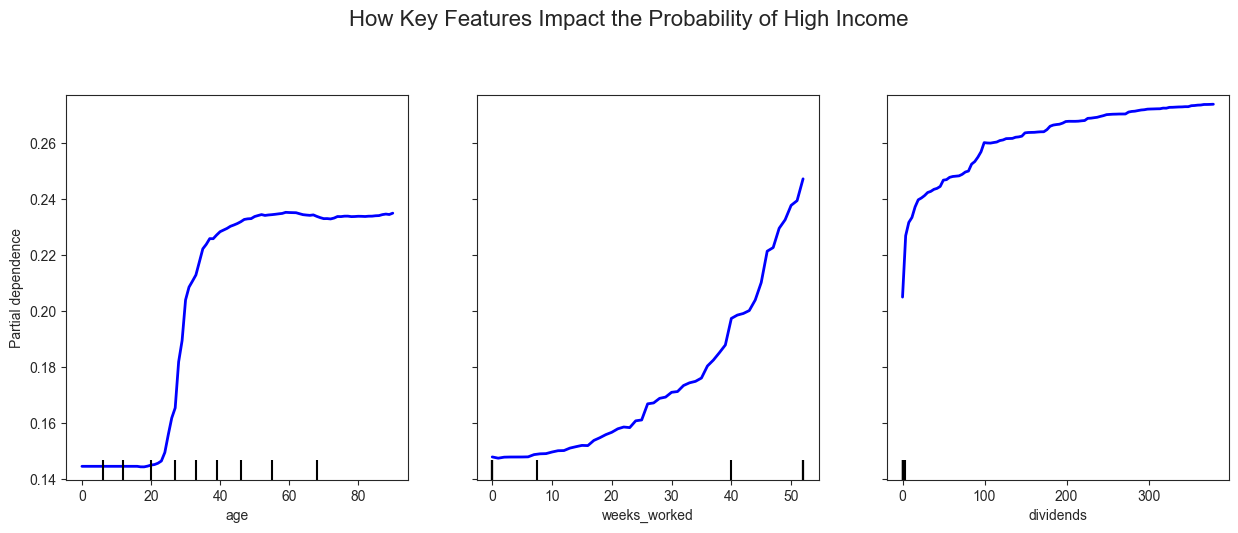

In [11]:
from interpretability import visualize_pdp

# Let's look at the shape of the top continuous drivers
# Ensure these column names match exactly what is in your X_train
features_of_interest = ['age', 'weeks_worked', 'dividends']

# Check if they exist before plotting to avoid errors
valid_features = [f for f in features_of_interest if f in X_train.columns]

visualize_pdp.plot_pdp(best_model, X_train, valid_features)

Generating Partial Dependence Plots...


/Users/gianjaeger/Desktop/Dataiku_assessment/assessment/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/gianjaeger/Desktop/Dataiku_assessment/assessment/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/g

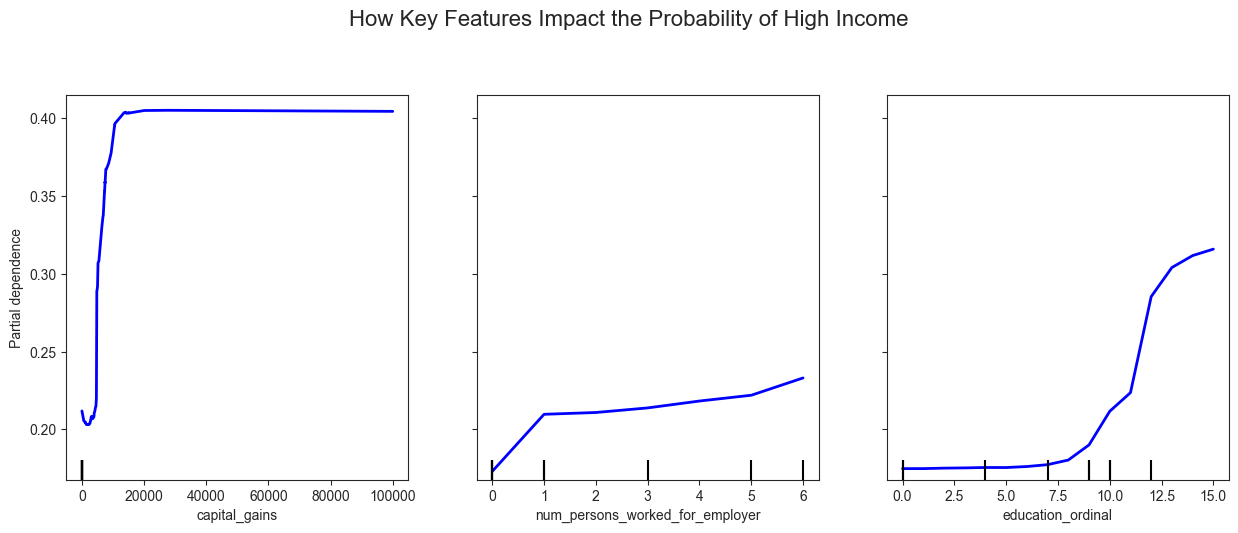

In [12]:
from interpretability import visualize_pdp

# Let's look at the shape of the top continuous drivers
features_of_interest = ['capital_gains', 'num_persons_worked_for_employer', 'education_ordinal']

visualize_pdp.plot_pdp(best_model, X_train, features_of_interest)

**See HOW exactly our categorical features impact the output**

Analyzing probability distribution for: major_occupation_code...


/Users/gianjaeger/Desktop/Dataiku_assessment/interpretability/visualize_categorical.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


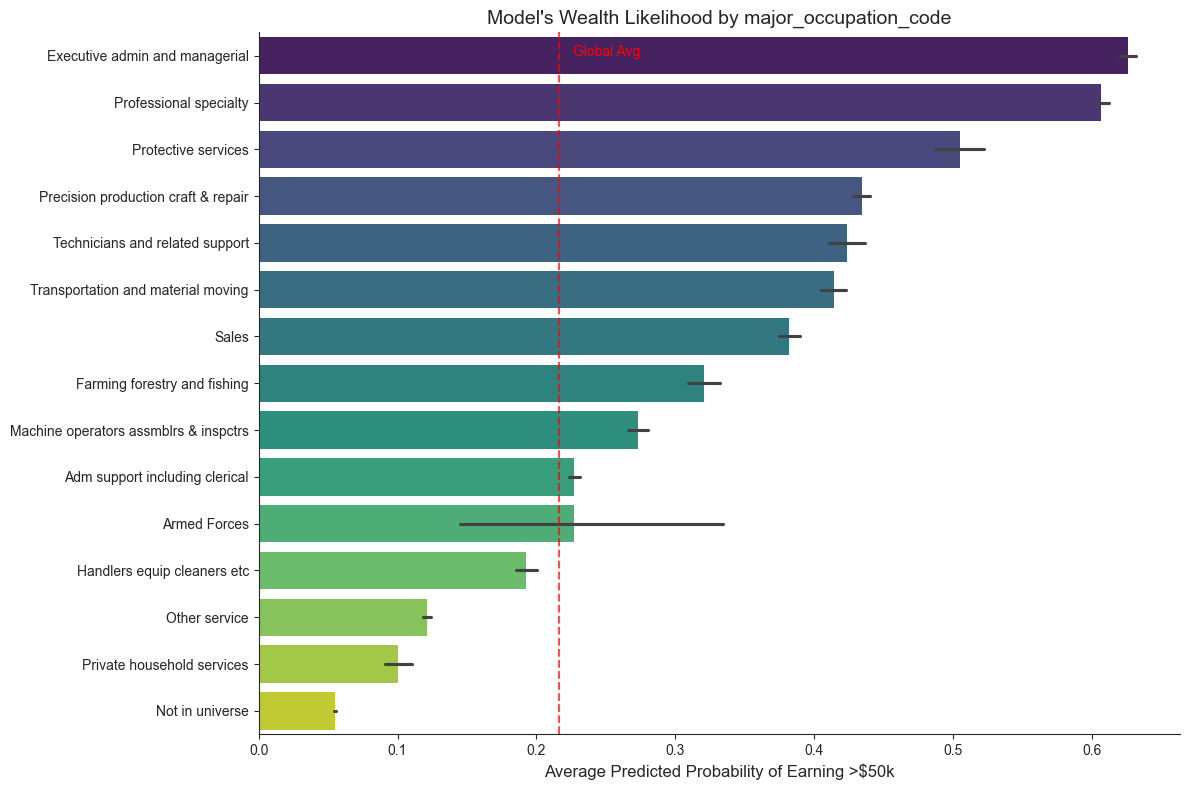

Analyzing probability distribution for: household_summary...


/Users/gianjaeger/Desktop/Dataiku_assessment/interpretability/visualize_categorical.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


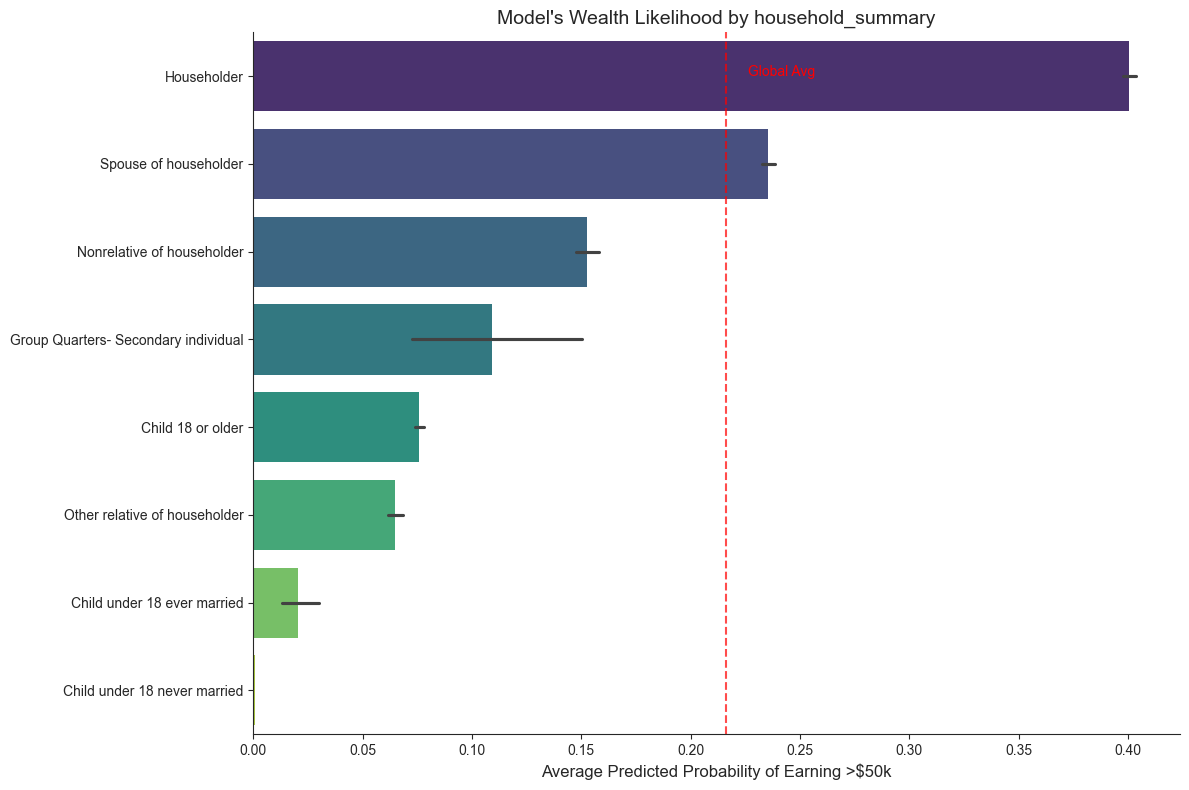

Analyzing probability distribution for: sex...


/Users/gianjaeger/Desktop/Dataiku_assessment/interpretability/visualize_categorical.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


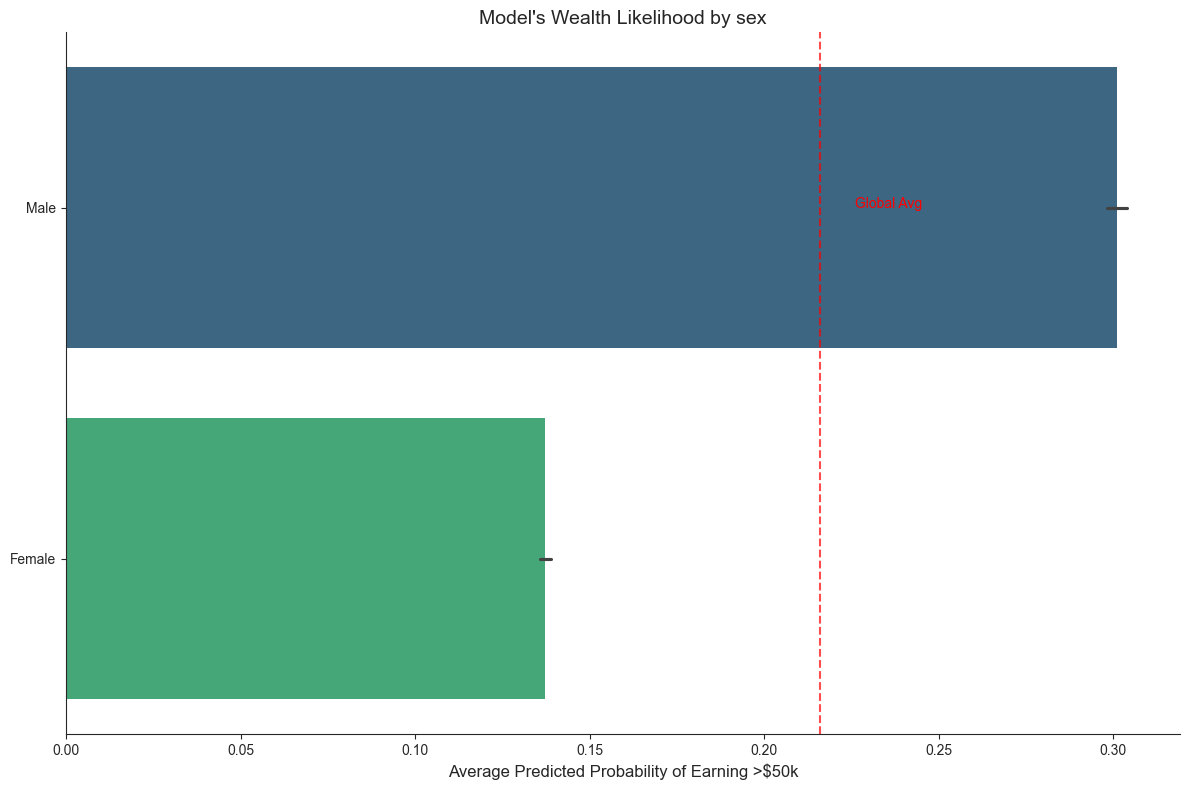

Analyzing probability distribution for: employment_status...


/Users/gianjaeger/Desktop/Dataiku_assessment/interpretability/visualize_categorical.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


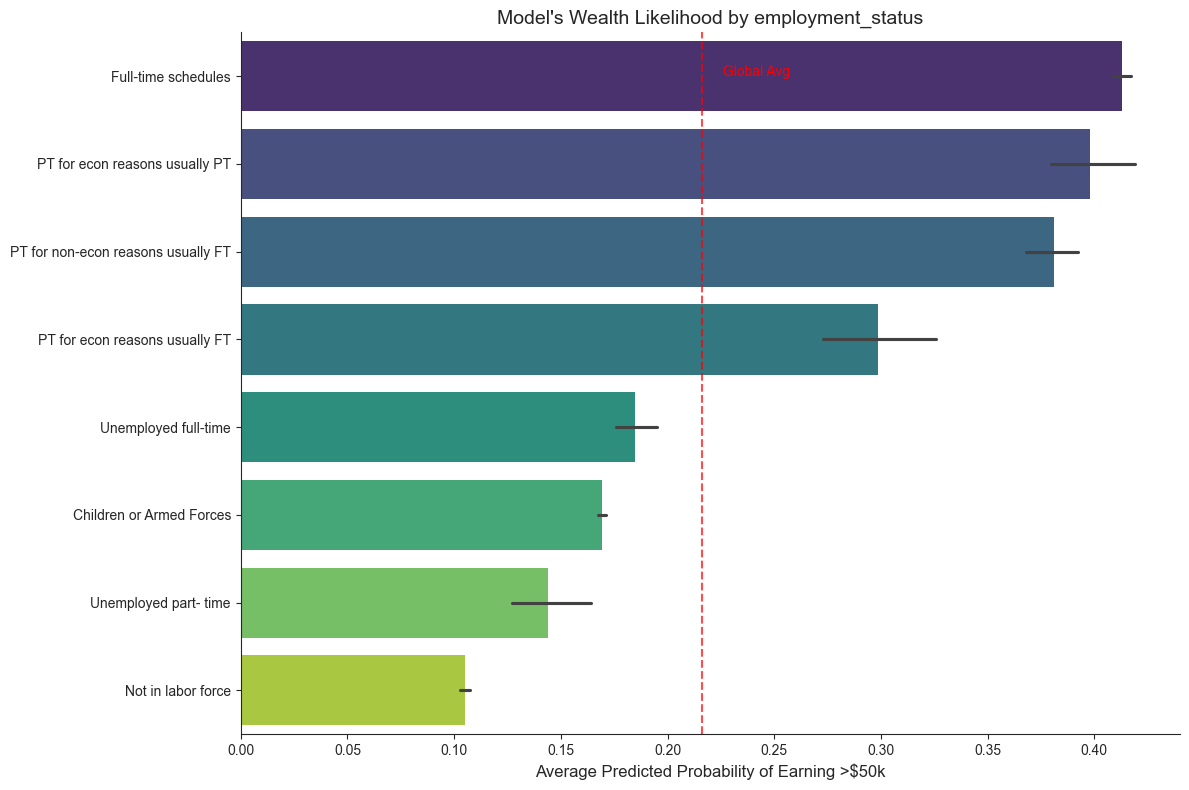

In [13]:
# Cell 14: Categorical Analysis
from interpretability import visualize_categorical

# 1. Identify the raw column names in 'test_df'
# You likely have: 'major_occupation_code', 'major_industry_code', 'race', 'sex'
cols_to_analyze = [
    'major_occupation_code', 
    'household_summary', 
    'sex',
    'employment_status'
]

# 2. Loop through and plot
for col in cols_to_analyze:
    # We check if the column exists in the raw dataframe first
    if col in test_df.columns:
        visualize_categorical.plot_categorical_probability(
            best_model, 
            X_test,       # The data the model reads (One-Hot)
            test_df,   # The data with the text labels
            col           # The column name
        )

**Visual of a single tree to better understand how random forest works as an ML predictor**

Training shallow proxy tree for visualization...


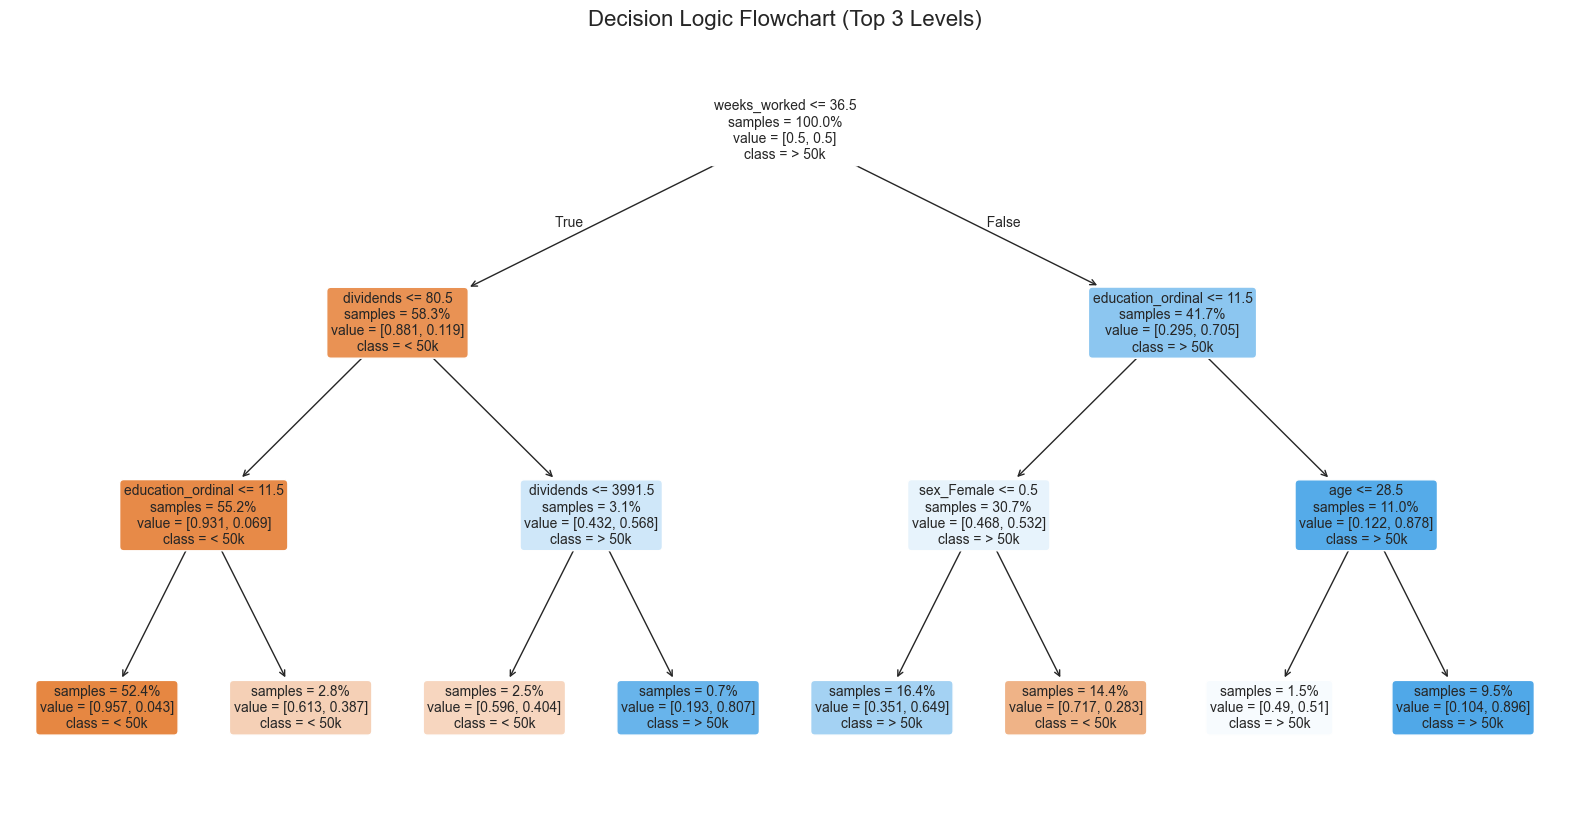

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [14]:
# Visualizing a single tree to understand decision rules (to be used in presentation)
from interpretability import visualize_tree

#Pass the feature names so the boxes say "Age <= 30" instead of "Feature 4 <= 30"
visualize_tree.plot_decision_rules(X_train, y_train, X_train.columns)

### Model 1: Logistic regression

Implemented with the following considerations:

- **Standard scaling (Z-score normalisation)**: applied to all continuous predictors to ensure stable coefficient estimation and prevent features with larger scales from dominating the optimisation

- **Model trained to maximise balanced accuracy**: enables a fair comparison across models in the presence of class imbalance

- **Interpretability via coefficient plots**: allows inspection of how each feature influences the log-odds of the positive class (sign and magnitude)

Logistic Regression training complete.
Scaled 6 continuous features.
--- Logistic Regression Evaluation ---
Balanced Accuracy: 87.01%
------------------------------
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     93575
           1       0.27      0.90      0.42      6186

    accuracy                           0.85     99761
   macro avg       0.63      0.87      0.67     99761
weighted avg       0.95      0.85      0.88     99761



/Users/gianjaeger/Desktop/Dataiku_assessment/assessment/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


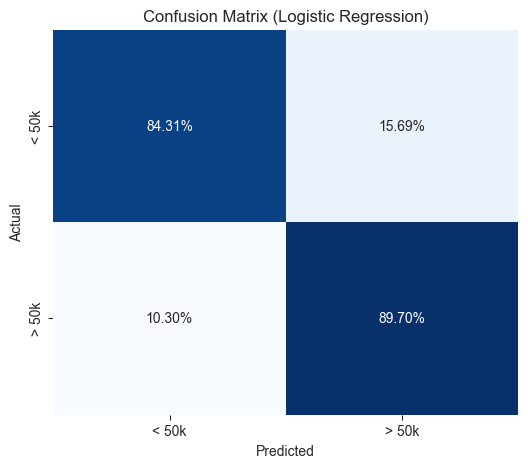

In [15]:
import importlib
from models import logistic_regression

# Train the model (numeric features get scaled in function)
log_model, scaler, scaled_cols = logistic_regression.train_scaled_logistic(X_train, y_train)
print("Logistic Regression training complete.")
print(f"Scaled {len(scaled_cols)} continuous features.")

# Run Evaluation on test set (for comparison with Random Forest)
logistic_regression.evaluate_logistic(log_model, scaler, scaled_cols, X_test, y_test)

/Users/gianjaeger/Desktop/Dataiku_assessment/models/logistic_regression.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


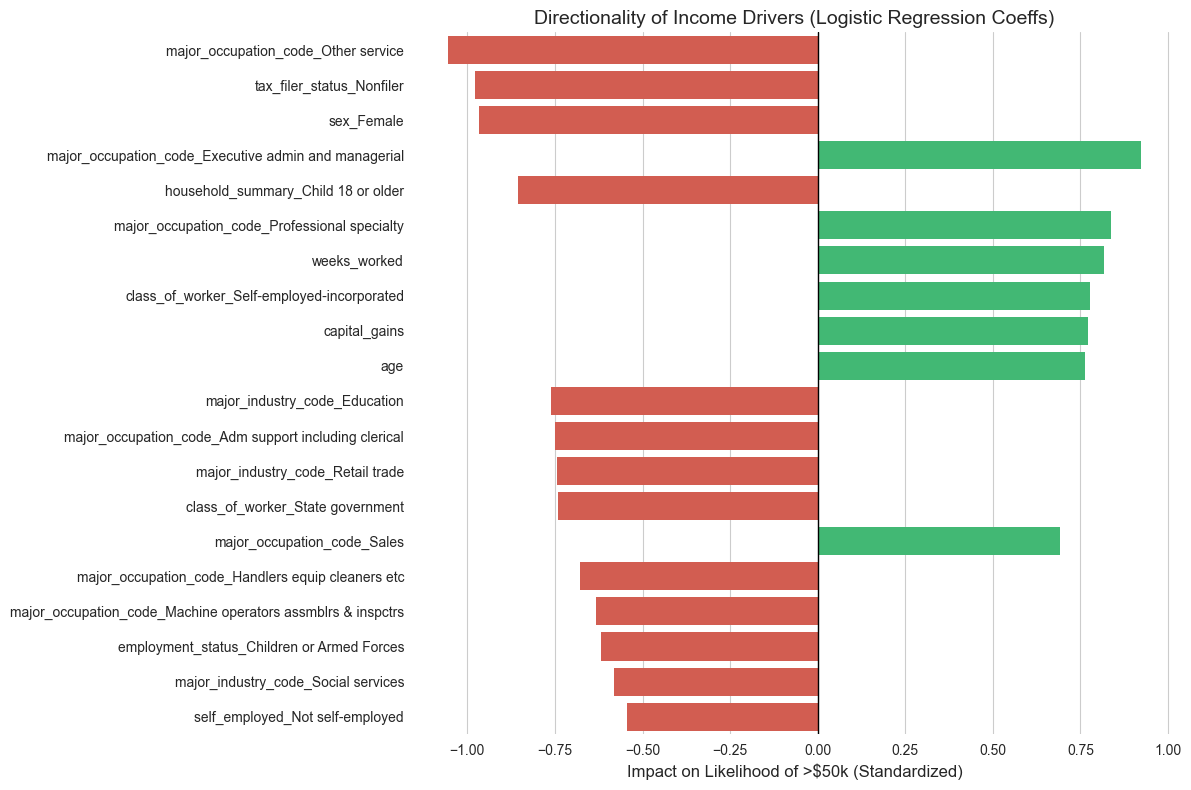

In [16]:
# Visualizing directionality for interpretability
logistic_regression.plot_coefficients(log_model, X_train.columns, top_n=20)

---